In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import cv2
import torch
import random
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import matplotlib.pyplot as plt
import time
import concurrent.futures

In [ ]:
# Paths
input_file_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup/FF/fake'
output_file_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup/FF/real'
meta_data_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup'
checkpoint_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup/checkpoints/best_checkpoint_FF.pth'
frames_required = 100
# valid_csv_path = f'{meta_data_path}/valid_videos.csv'
# valid_csv_path = f'{meta_data_path}/valid_videos_old.csv'

In [ ]:
import pandas as pd
import os

# 기존 csv 파일 경로
csv_path = f'{meta_data_path}/valid_videos.csv'

# 새로운 기본 경로
base_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup/FF'

# CSV 읽기 (헤더 있음)
df = pd.read_csv(csv_path)

def replace_path(old_path):
    filename = os.path.basename(old_path)
    if 'real' in old_path.lower():
        return os.path.join(base_path, 'real', filename)
    elif 'fake' in old_path.lower():
        return os.path.join(base_path, 'fake', filename)
    else:
        # real/fake 단어가 없으면 원래 경로 유지하거나 처리
        return old_path

df['video_path'] = df['video_path'].apply(replace_path)

df.to_csv(f'{meta_data_path}/valid_videos_FF.csv', index=False)

print("[INFO] 경로 변경 완료. valid_video_updated.csv 파일로 저장되었습니다.")


[INFO] 경로 변경 완료. valid_video_updated.csv 파일로 저장되었습니다.


In [ ]:
valid_csv_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup/filtered.csv'

In [ ]:
import pandas as pd
import os

# CSV 파일 경로 (수정 필요)
csv_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup/valid_videos_FF.csv'
df = pd.read_csv(csv_path)

# validation 폴더 경로 (수정 필요)
validation_dir = '/content/drive/MyDrive/class/capstone_com/datasetbackup/FF/validation'

# validation 폴더 내 파일/폴더 이름들 (확장자 포함 여부에 따라 조정)
validation_files = set(os.listdir(validation_dir))

# video_path에서 마지막 경로만 추출 (폴더명 or 파일명)
df['video_name'] = df['video_path'].apply(lambda x: os.path.basename(x))

# validation에 이미 있는 항목은 제외
filtered_df = df[~df['video_name'].isin(validation_files)]

# 필요시 결과 저장
filtered_df.to_csv('/content/drive/MyDrive/class/capstone_com/datasetbackup/filtered.csv', index=False)


In [ ]:
# Transform
im_size = 112
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Frame extractor
def frame_extract(path):
    cap = cv2.VideoCapture(path)
    success, image = cap.read()
    while success:
        yield image
        success, image = cap.read()
    cap.release()

# Validate a single video
def validate_and_count(video_path, transform, required_frames=20):
    try:
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        if total_frames < frames_required:
            return None

        frames = []
        for i, frame in enumerate(frame_extract(video_path)):
            if frame is None: break
            frames.append(transform(frame))
            if len(frames) == required_frames:
                break
        if len(frames) < required_frames:
            return None
        return video_path, total_frames
    except:
        return None

# Step 1 & 2: Validate and filter videos (with CSV caching)
video_files = glob.glob(f'{input_file_path}/*.mp4') + glob.glob(f'{output_file_path}/*.mp4')
print(f"[INFO] Total videos before validation: {len(video_files)}")


[INFO] Total videos before validation: 1929


In [ ]:
if os.path.exists(valid_csv_path):
    print("[INFO] Loading validated video list from CSV...")
    valid_df = pd.read_csv(valid_csv_path)
    valid_videos = valid_df['video_path'].tolist()
    frame_counts = valid_df['frame_count'].tolist()
else:
    print("[INFO] Validating videos...")
    valid_videos = []
    frame_counts = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        futures = [executor.submit(validate_and_count, v, transform) for v in video_files]
        for f in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Validating videos"):
            result = f.result()
            if result:
                valid_videos.append(result[0])
                frame_counts.append(result[1])
    valid_df = pd.DataFrame({
        'video_path': valid_videos,
        'frame_count': frame_counts
    })
    valid_df.to_csv(valid_csv_path, index=False)
    print(f"[INFO] Saved {len(valid_videos)} valid videos to valid_videos.csv")

print(f"[INFO] Valid videos: {len(valid_videos)} | Avg frames: {np.mean(frame_counts):.2f}")


[INFO] Loading validated video list from CSV...
[INFO] Valid videos: 1727 | Avg frames: 148.00


In [ ]:
# Step 3: Dataset and Dataloader
label_df = pd.read_csv(f'{meta_data_path}/metadata.csv', sep='\t', names=["file", "label"])
# label_df = label_df.dropna(subset=["file","label"])

# label_dict = {row["file"]: 0 if str(row["label"]).strip().lower() == "fake" else 1 for _, row in label_df.iterrows()}

print(label_df.columns)
# dropna와 dict 생성
label_df = label_df.dropna(subset=["file", "label"])
label_df["file"] = label_df["file"].apply(lambda x: os.path.splitext(os.path.basename(str(x).strip()))[0])

label_dict = {
    row["file"]: 0 if str(row["label"]).strip().lower() == "fake" else 1
    for _, row in label_df.iterrows()
}

class VideoDataset(Dataset):
    def __init__(self, video_paths, label_dict, sequence_length=10, transform=None):
        self.video_paths = video_paths
        self.label_dict = label_dict
        self.sequence_length = sequence_length
        self.transform = transform

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        frames = []

        for frame in frame_extract(video_path):
            if frame is None: continue
            frames.append(self.transform(frame))
            if len(frames) == self.sequence_length:
                break
        if len(frames) == 0:
            raise RuntimeError(f"No frames extracted from video: {video_path}")

        # frames = torch.stack(frames[:self.sequence_length])
        # label = self.label_dict.get(os.path.basename(video_path), 0)

        file_key = os.path.splitext(os.path.basename(video_path))[0]
        label = self.label_dict.get(file_key, 0)  # fallback은 0

        return frames, label

Index(['file', 'label'], dtype='object')


In [ ]:
import os
import torch
from torch.utils.data import Dataset
import cv2

class VideoDataset(Dataset):
    def __init__(self, video_paths, label_dict, sequence_length=10, transform=None):
        self.sequence_length = sequence_length
        self.transform = transform
        self.label_dict = label_dict

        # ✅ 유효한 영상만 필터링
        self.video_paths = []
        for path in video_paths:
            if self.is_valid_video(path):
                self.video_paths.append(path)
            else:
                print(f"[Warning] Invalid video skipped: {path}")

    def is_valid_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        ret, _ = cap.read()
        cap.release()
        return ret  # 첫 프레임을 읽을 수 있으면 True

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        frames = []

        for frame in frame_extract(video_path):
            if frame is None:
                continue
            frames.append(self.transform(frame))
            if len(frames) == self.sequence_length:
                break

        if len(frames) == 0:
            raise RuntimeError(f"No frames extracted from video: {video_path}")

        frames = torch.stack(frames[:self.sequence_length])

        file_key = os.path.splitext(os.path.basename(video_path))[0]
        label = self.label_dict.get(file_key, 0)

        return frames, label


In [ ]:
class VideoDataset(Dataset):
    def __init__(self, video_paths, label_dict, sequence_length=10, transform=None):
        self.video_paths = video_paths
        self.label_dict = label_dict
        self.sequence_length = sequence_length
        self.transform = transform

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        frames = []

        for frame in frame_extract(video_path):
            if frame is None: continue
            frames.append(self.transform(frame))
            if len(frames) == self.sequence_length:
                break
        if len(frames) == 0:
            raise RuntimeError(f"No frames extracted from video: {video_path}")

        # Uncomment this line to stack the list of frame tensors into a single tensor
        frames = torch.stack(frames[:self.sequence_length])
        # label = self.label_dict.get(os.path.basename(video_path), 0)

        file_key = os.path.splitext(os.path.basename(video_path))[0]
        label = self.label_dict.get(file_key, 0)  # fallback은 0

        return frames, label

In [ ]:
from collections import Counter
label_counts = Counter(label_dict.values())
print(f"Updated label distribution: {label_counts}")
# 기대 결과: Counter({0: xxx, 1: yyy})  // fake와 real 적절히 섞여 있어야 함

print(f"Train size: {len(train_videos)}")
print(f"Val size: {len(val_videos)}")
print(f"Intersection: {len(set(train_videos) & set(val_videos))}")



Updated label distribution: Counter({1: 2513, 0: 2362})
Train size: 1250
Val size: 537
Intersection: 0


In [ ]:
# CSV 파일을 제대로 읽고 있는지 확인
# label_df = pd.read_csv(f'{meta_data_path}/metadata.csv')
# print(label_df.head())
# print(label_df.columns)

In [ ]:
# Train/Val Split
random.shuffle(valid_videos)
train_split = int(0.7 * len(valid_videos))
train_videos = valid_videos[:train_split]
val_videos = valid_videos[train_split:]

train_data = VideoDataset(train_videos, label_dict, transform=transform)
val_data = VideoDataset(val_videos, label_dict, transform=transform)

train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=6)
val_loader = DataLoader(val_data, batch_size=4, shuffle=False, num_workers=6)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Step 4: Model
class Model(nn.Module):
    def __init__(self, num_classes=2, latent_dim=1280, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        base = models.efficientnet_b0(pretrained=True)
        self.features = base.features
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        x = self.features(x)
        x = self.avgpool(x).view(B, T, -1)
        x, _ = self.lstm(x)
        out = self.fc(self.dropout(x.mean(dim=1)))
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# ✅ Focal Loss 정의
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

# ✅ 모델 정의: EfficientNet + Bi-LSTM
class Model(nn.Module):
    def __init__(self, num_classes=2, latent_dim=1280, lstm_layers=1, hidden_dim=2048, bidirectional=True):
        super(Model, self).__init__()
        base = models.efficientnet_b0(pretrained=True)
        self.features = base.features  # EfficientNetB0 feature extractor
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional=bidirectional)
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim

        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(lstm_output_dim, num_classes)

    def forward(self, x):
        # x shape: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)

        # CNN feature extraction
        x = self.features(x)
        x = self.avgpool(x)  # shape: (B*T, latent_dim, 1, 1)
        x = x.view(B, T, -1)  # shape: (B, T, latent_dim)

        # LSTM
        x, _ = self.lstm(x)  # shape: (B, T, hidden_dim * 2)

        # Temporal average pooling
        x = x.mean(dim=1)  # shape: (B, hidden_dim * 2)

        # Fully connected
        x = self.dropout(x)
        out = self.fc(x)
        return out

# ✅ 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ 모델 초기화
model = Model().to(device)

# ✅ 손실 함수: Focal Loss
criterion = FocalLoss(alpha=1, gamma=2)

# ✅ 옵티마이저
optimizer = optim.Adam(model.parameters(), lr=0.0001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Step 5: Train & Evaluate
def calculate_accuracy(outputs, targets):
    _, preds = outputs.max(1)
    return (preds == targets).float().mean().item() * 100

def train_epoch(epoch, model, loader, criterion, optimizer):
    model.train()
    total_loss, total_acc = 0, 0
    start_time = time.time()

    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)
        acc = calculate_accuracy(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += acc

        if (i + 1) % 10 == 0:
            elapsed = time.time() - start_time
            eta = elapsed / (i + 1) * (len(loader) - i - 1)
            print(f"\r[Train] Epoch {epoch} | Batch {i+1}/{len(loader)} | Loss: {loss.item():.4f} | Acc: {acc:.2f}% | ETA: {eta:.1f}s", end="")

    print()
    return total_loss / len(loader), total_acc / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_acc = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            acc = calculate_accuracy(outputs, y)

            total_loss += loss.item()
            total_acc += acc

            preds = outputs.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(y.cpu().numpy())

    return total_loss / len(loader), total_acc / len(loader), y_true, y_pred


In [ ]:
'''# Step 6: Training Loop
train_losses, val_losses = [], []
train_accs, val_accs = [], []

epochs = 10
for epoch in range(1, epochs + 1):
    print(f"\n[INFO] Starting Epoch {epoch}/{epochs}")
    train_loss, train_acc = train_epoch(epoch, model, train_loader, criterion, optimizer)
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"[INFO] Epoch {epoch} Completed | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

'''




[INFO] Starting Epoch 1/10


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "<ipython-input-22-fcf752e78103>", line 21, in __getitem__
    raise RuntimeError(f"No frames extracted from video: {video_path}")
RuntimeError: No frames extracted from video: /content/drive/MyDrive/class/capstone_com/datasetbackup/fake/019_018.mp4


In [ ]:
def load_checkpoint(path, model, optimizer):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_val_acc = checkpoint['val_acc']
        print(f"[INFO] Loaded checkpoint from epoch {start_epoch} with best val acc: {best_val_acc:.2f}%")
        return start_epoch, best_val_acc
    else:
        print("[INFO] No checkpoint found. Starting from scratch.")
        return 0, 0.0


In [ ]:
# 학습 설정
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epochs = 10
# checkpoint_path = 'best_checkpoint.pth'

# 체크포인트 로딩
start_epoch, best_val_acc = load_checkpoint(checkpoint_path, model, optimizer)

# 이어서 학습
for epoch in range(start_epoch + 1, epochs + 1):
    print(f"\n[INFO] Starting Epoch {epoch}/{epochs}")
    train_loss, train_acc = train_epoch(epoch, model, train_loader, criterion, optimizer)
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(train_losses)
    print(f"[INFO] Epoch {epoch} Completed | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # 최고 성능 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': best_val_acc
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"[INFO] Saved checkpoint at Epoch {epoch} with Val Acc: {val_acc:.2f}%")

print("[INFO] Training Complete")


[INFO] Loaded checkpoint from epoch 10 with best val acc: 91.41%
[INFO] Training Complete


In [ ]:
# 전체 모델 저장
torch.save(model, '/content/drive/MyDrive/class/capstone_com/datasetbackup/final_model_FF.pth')

In [ ]:
def get_device():
    if torch.backends.mps.is_available():
        print("MPS is available. Using MPS.")
        device = torch.device("mps")
    elif torch.cuda.is_available():
        print("CUDA is available. Using CUDA.")
        device = torch.device("cuda")
    else:
        print("CUDA and MPS not available. Using CPU.")
        device = torch.device("cpu")
    return device

# 디바이스 설정
device = get_device()
print(f"✅ Using device: {device}")

CUDA is available. Using CUDA.
✅ Using device: cuda



[CONFUSION MATRIX]:
 [[214  19]
 [ 25 261]]

[CLASSIFICATION REPORT]:
              precision    recall  f1-score   support

        Fake       0.90      0.92      0.91       233
        Real       0.93      0.91      0.92       286

    accuracy                           0.92       519
   macro avg       0.91      0.92      0.91       519
weighted avg       0.92      0.92      0.92       519



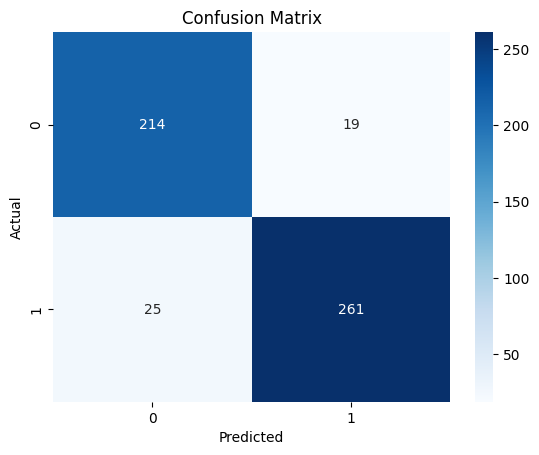

In [ ]:
# Step 7: Confusion Matrix
def print_confusion(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print("\n[CONFUSION MATRIX]:\n", cm)
    print("\n[CLASSIFICATION REPORT]:")
    print(classification_report(y_true, y_pred, target_names=["Fake", "Real"]))
    sn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

print_confusion(y_true, y_pred)

In [ ]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

# Import the Model class definition from earlier in your notebook
# Make sure the Model class is defined before this cell runs
# from your_model_file import Model # If your model is in a separate file

# === 1. 설정 ===
validation_root = '/content/drive/MyDrive/class/capstone_com/datasetbackup/FF/validation'  # 여기를 실제 경로로 수정
frames_required = 100
label_map = {'real': 0, 'fake': 1}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 2. 영상에서 일정 수의 프레임 추출 함수 ===
def extract_frames_from_video(video_path, num_frames=100):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idxs = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)

    frames = []
    for idx in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break
        if idx in frame_idxs:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    cap.release()
    return frames

# === 3. Transform 정의 ===
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# === 4. Dataset 정의 ===
class ValidationVideoDataset(Dataset):
    def __init__(self, root_dir, transform=None, frames_required=100):
        self.samples = []
        self.transform = transform
        self.frames_required = frames_required

        for label_name in ['real', 'fake']:
            class_dir = os.path.join(root_dir, label_name)
            if not os.path.isdir(class_dir):
                print(f"[Warning] Directory not found: {class_dir}")
                continue
            for filename in os.listdir(class_dir):
                if filename.endswith('.mp4'):
                    self.samples.append((os.path.join(class_dir, filename), label_map[label_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        frames = extract_frames_from_video(video_path, self.frames_required)

        if not frames:
            # Handle case where no frames are extracted
            print(f"[Warning] No frames extracted from {video_path}. Skipping.")
            # You might want to return None and handle it in the DataLoader loop,
            # or return a dummy tensor/skip the sample during dataset creation.
            # For simplicity here, we raise an error, but a more robust approach
            # would be to filter out invalid videos during dataset initialization.
            raise RuntimeError(f"No frames extracted from video: {video_path}")


        # transform each frame
        transformed_frames = [self.transform(frame) for frame in frames]
        frames_tensor = torch.stack(transformed_frames)  # Shape: [T, C, H, W]
        return frames_tensor, label

# === 5. 모델 불러오기 ===
# Instantiate the model with the same architecture as the saved checkpoint
# Ensure the Model class is defined in your notebook or imported
model = Model().to(device) # Create an instance of your Model class

# Load the checkpoint dictionary
checkpoint = torch.load('/content/drive/MyDrive/class/capstone_com/datasetbackup/checkpoints/best_checkpoint_FF.pth', map_location=device)

# Load the state_dict from the checkpoint into the model instance
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()

# === 6. DataLoader 만들기 ===
val_dataset = ValidationVideoDataset(validation_root, transform=transform, frames_required=frames_required)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# === 7. 평가 ===
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        # Ensure inputs have the correct shape for the model (B, T, C, H, W)
        # DataLoader with batch_size=1 will have shape [1, T, C, H, W] which is correct
        inputs = inputs.to(device)

        # Labels from Dataset might be a list/int, ensure it's a tensor
        labels = torch.tensor([labels]).to(device) # Wrap labels in a list if batch_size=1

        outputs = model(inputs)  # outputs shape: [1, 2]
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy()) # Extract scalar if batch_size=1

# === 8. 결과 출력 ===
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['real', 'fake']))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 120/120 [01:37<00:00,  1.23it/s]

Accuracy: 0.525
Classification Report:
              precision    recall  f1-score   support

        real       0.52      0.82      0.63        60
        fake       0.56      0.23      0.33        60

    accuracy                           0.53       120
   macro avg       0.54      0.53      0.48       120
weighted avg       0.54      0.53      0.48       120



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import os
import numpy as np
import cv2
import glob
import random

# Step 1: 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# Step 2: 모델 정의
class Model(nn.Module):
    def __init__(self, num_classes=2, latent_dim=1280, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        base = models.efficientnet_b0(pretrained=True)
        self.features = base.features
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), num_classes)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        x = self.features(x)
        x = self.avgpool(x).view(B, T, -1)
        x, _ = self.lstm(x)
        out = self.fc(self.dropout(x.mean(dim=1)))
        return out

# Step 3: 모델 및 옵티마이저 초기화
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Step 4: 체크포인트 로드
checkpoint_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup/checkpoints/best_checkpoint_FF.pth'  # ✅ 여기를 실제 경로로 수정하세요
checkpoint = torch.load(f'{checkpoint_path}', map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()
print("✅ Model loaded and set to eval mode.")

# Step 5: 전처리 정의
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Step 6: 테스트 비디오 로드
test_input_file_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup/FF/validation/fake'    # ✅ 수정 필요
test_output_file_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup/FF/validation/real'  # ✅ 수정 필요
frames = 32  # 프레임 수 임계값 (예시)

new_video_files = glob.glob(f'{test_input_file_path}/*.mp4') + glob.glob(f'{test_output_file_path}/*.mp4')
random.shuffle(new_video_files)

frame_count = []
short_frame = []

for video_file in reversed(new_video_files):  # 뒤에서부터 삭제하기 위해 reversed
    cap = cv2.VideoCapture(video_file)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < frames:
        new_video_files.remove(video_file)
        short_frame.append(video_file)
        continue
    frame_count.append(total_frames)
    cap.release()

print("🎞️ Frame counts:", frame_count)
print("📁 Total valid videos:", len(frame_count))
print("📊 Average frames per video:", np.mean(frame_count))
print("⛔ Short videos removed:", len(short_frame))


✅ Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Model loaded and set to eval mode.
🎞️ Frame counts: [148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148]
📁 Total valid videos: 120
📊 Average frames per video: 148.0
⛔ Short videos removed: 0


In [ ]:
# === 수정된 Dataset ===
class ValidationVideoDataset(Dataset):
    def __init__(self, root_dir, transform=None, frames_required=100):
        self.samples = []
        self.transform = transform
        self.frames_required = frames_required

        for label_name in ['real', 'fake']:
            class_dir = os.path.join(root_dir, label_name)
            if not os.path.isdir(class_dir):
                print(f"[Warning] Directory not found: {class_dir}")
                continue
            for filename in os.listdir(class_dir):
                if filename.endswith('.mp4'):
                    self.samples.append((os.path.join(class_dir, filename), label_map[label_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        frames = extract_frames_from_video(video_path, self.frames_required)

        if not frames:
            raise RuntimeError(f"No frames extracted from video: {video_path}")

        transformed_frames = [self.transform(frame) for frame in frames]
        frames_tensor = torch.stack(transformed_frames)  # Shape: [T, C, H, W]
        return frames_tensor, label, video_path

# === 평가 루프 수정 ===
all_preds = []
all_labels = []
all_scores = []
video_paths = []

with torch.no_grad():
    for frames, label, path in tqdm(val_loader):
        # frames shape: [1, T, C, H, W] → [B, T, C, H, W]
        frames = frames.to(device)
        label = torch.tensor([label], dtype=torch.long).to(device)  # label -> [1]

        output = model(frames)  # output shape: [1, 2]
        pred = torch.argmax(output, dim=1).item()
        prob_fake = torch.softmax(output, dim=1)[0, 1].item()

        all_preds.append(pred)
        all_labels.append(label.item())
        all_scores.append(prob_fake)
        video_paths.append(path[0])  # path is a tuple of 1 item (from batch_size=1)

# === 결과 출력 및 저장 ===
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

print("✅ Accuracy:", accuracy_score(all_labels, all_preds))
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['real', 'fake']))

# 결과 저장
results_dir = '/content/drive/MyDrive/class/capstone_com/results'
os.makedirs(results_dir, exist_ok=True)

results_df = pd.DataFrame({
    'video_path': video_paths,
    'true_label': all_labels,
    'predicted_label': all_preds,
    'fake_probability': all_scores
})
results_df.to_csv(os.path.join(results_dir, 'test_predictions.csv'), index=False)

# 오분류 분석
misclassified = results_df[results_df['true_label'] != results_df['predicted_label']]
print(f"\n❌ Number of misclassified videos: {len(misclassified)} out of {len(results_df)}")

if len(misclassified) > 0:
    print("\n🔍 Sample of misclassified videos:")
    for i, (_, row) in enumerate(misclassified.head(5).iterrows()):
        print(f"📼 Video: {row['video_path']}")
        print(f"   ✅ True label: {'Fake' if row['true_label'] == 1 else 'Real'}")
        print(f"   ❌ Predicted: {'Fake' if row['predicted_label'] == 1 else 'Real'}")
        print(f"   🔢 Fake probability: {row['fake_probability']:.4f}")
        print("---")

print(f"\n✅ Evaluation complete. Results saved to: {results_dir}")
print("\n🏁 Deepfake detection model training and evaluation completed successfully!")


  0%|          | 0/120 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 3, got 2)